<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Требуется построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

<u>План работы</u>

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
# импортируем необходимые для работы библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

pd.set_option('display.max_columns', None)

%matplotlib inline

plt.rcParams['figure.figsize'] = (20, 8)

RANDOM_STATE = 42

In [2]:
# сохраним датафрейм в переменную
data = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
# просмотрим первые строки датафрейма
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Мы видим, что данные о заказах фиксировались с переодичностью в 10 минут.

In [4]:
# посмотрим общую информацию о наборе данных
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Проверим, расположены ли даты в наборе в хронологическом порядке.

In [5]:
if data.index.is_monotonic is True:
    print('Даты в датафрейме представлены в хронологическом порядке')
else:
    print('Даты в датафрейме представлены НЕ в хронологическом порядке')

Даты в датафрейме представлены в хронологическом порядке


Из общей информации видно, что пропусков нет. В датфрейме представлены данные *с 1 марта по 31 августа 2018 года*. Данные в датафрейме представлены в хронологическом порядке.

Считаю, что проверка наличия явных дубликатов в данном нецелесообразна, поскольку их присутствие может означать, что в определенных временных периодах наблюдается цикличность, а значит и удалять мы их все равно не будем.

Выполним ресемплирование данных по одному часу.

In [6]:
data = data.resample('1H').sum()

**Вывод:**
    
Датафрейм состоит из двух столбцов:

* `datetime` — время и дата заказов
* `num_orders` — количество заказов

В таблице содержатся *данные с 1 марта по 31 августа 2018 года*.

Пропусков нет, данные в датафрейме представлены в хронологическом порядке, наличие явных дубликатов не проверялось.

Исходный интервал получения данных был 10 минут, выполнено рассемплирование данных с интервалом в 1 час.

## Анализ

Построим график для оценки временного ряда.

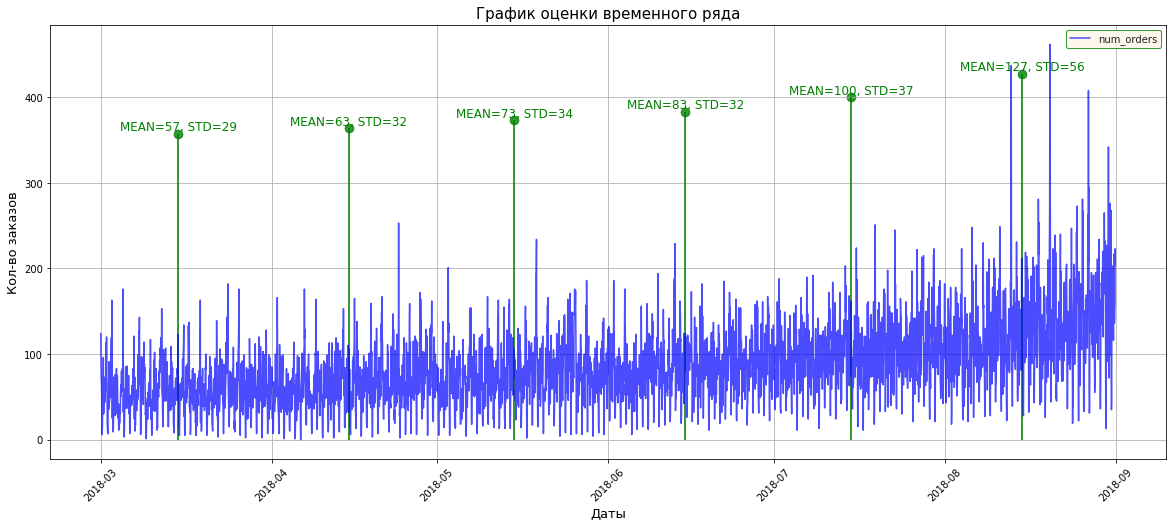

In [7]:
plt.title('График оценки временного ряда', fontsize=15)
sns.set_style('darkgrid')
plt.plot(data, label='num_orders', alpha=0.7, color='blue')
plt.xticks(fontsize=10, rotation=45)

for month in data.index.month.unique():
    mean_for_month = np.mean(data[f"2018-{month}":f"2018-{month}"])
    std_for_month = np.std(data[f"2018-{month}":f"2018-{month}"])
    
    plt.vlines(pd.to_datetime(f'2018-{month}-15'), ymin=0, ymax=(mean_for_month)+300, color='green', alpha=0.8, linewidth=2)
    plt.scatter(x=pd.to_datetime(f'2018-{month}-15'), y=(mean_for_month)+300, s=75, color='green', alpha=0.8)
    plt.text(x=pd.to_datetime(f'2018-{month}-15'), y=(mean_for_month)+300, 
             s=f'MEAN={int(mean_for_month)}, STD={int(std_for_month)}', 
             horizontalalignment='center', verticalalignment='bottom', fontsize=12, color='green')
    
plt.ylabel('Кол-во заказов', fontsize=13)
plt.xlabel('Даты', fontsize=13)
plt.grid(True)
plt.legend(edgecolor='green', facecolor='oldlace');

По графику видно, что мы имеем дело с нестационарным рядом, поскольку средние значения и стандартные отклонения изменяются. Так как нестационарные ряды трудно прогнозировать, нужно сделать его стационарным. Для этого добавим новые признаки для горизонта прогнозирования.

Добавим час, день недели, отстающие значения (предыдущие значения временного ряда) и скользящее среднее.

In [8]:
# напишем функцию создания новых признаков
def make_features(data, max_lag, rolling_mean_size):
    df = data.copy()
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df['num_orders'].shift(lag)
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return df

Теперь вызовем эту функцию, указав максимальное количество лагов и размер окна скользящего среднего.

In [9]:
make_features(data, 2, 12)

,num_orders,hour,day,dayofweek,lag_1,lag_2,rolling_mean
datetime,,,,,,,
2018-03-01 00:00:00,124,0,1,3,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,1,3,124.0,NaN,NaN
2018-03-01 02:00:00,71,2,1,3,85.0,124.0,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,NaN
2018-03-01 04:00:00,43,4,1,3,66.0,71.0,NaN
...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,19,31,4,207.0,217.0,163.416667
2018-08-31 20:00:00,154,20,31,4,136.0,207.0,170.916667
2018-08-31 21:00:00,159,21,31,4,154.0,136.0,168.583333


Посмотрим на получившийся датафрейм.

In [10]:
data.head(20)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


Для первых дат в датафрейме есть не все значения, поэтому там стоит NaN. Эти строки удалим.

In [11]:
data = data.dropna()

In [12]:
data.head(20)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


На графике *'График оценки временного ряда'* (выше) мы видим, что среднее значение количества заказов растет от месяца к месяцу.
Построим график распределения заказов такси по месяцам.

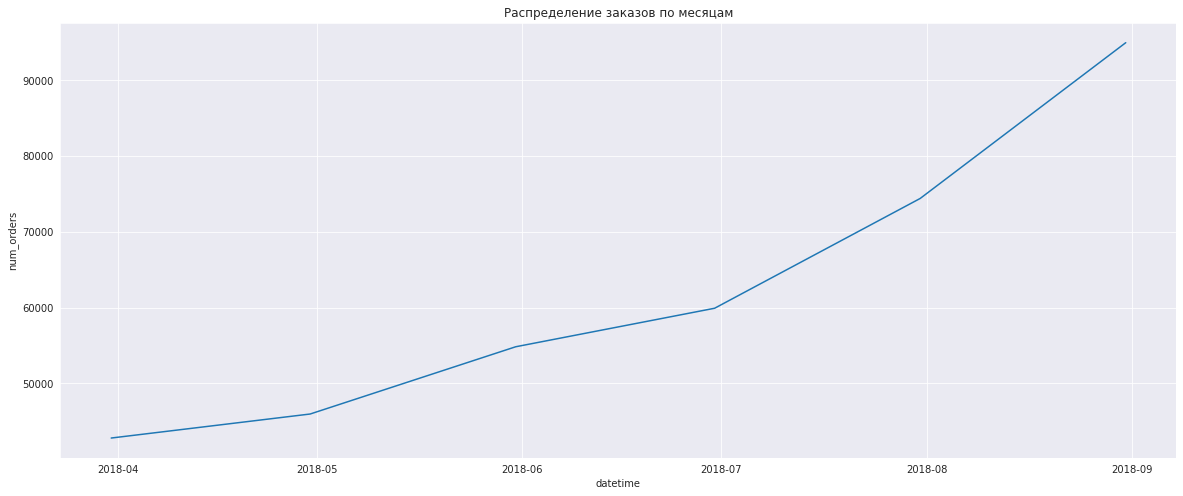

In [13]:
month = data.resample('1M').sum()
sns.lineplot(x=month.index, y=month['num_orders']).set_title('Распределение заказов по месяцам');

Итак, количество заказов стабильно растет от месяца к месяцу, особенно значительный рост наблюдается с начала июля до конца августа.

Оценим тренд.

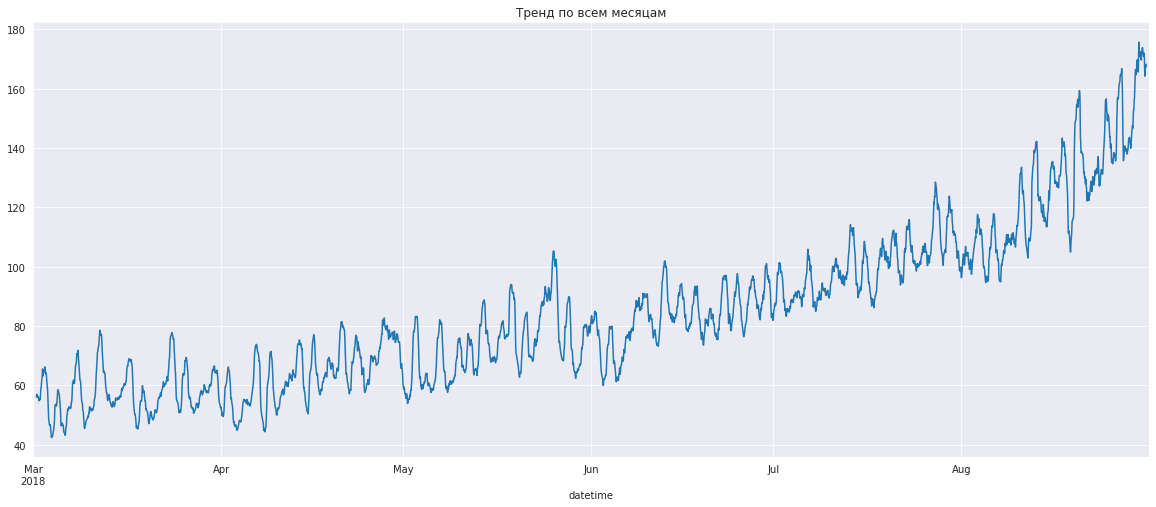

In [14]:
decomposed = seasonal_decompose(data['num_orders'])
decomposed.trend.plot(ax=plt.gca(), title='Тренд по всем месяцам');

Данный график подтверждает выводы, полученные выше.

Оценим сезонность данных на примере одного месяца, возьмем для этой оценки июль, как месяц в котором наблюдался значительный рост, но не максимальный.

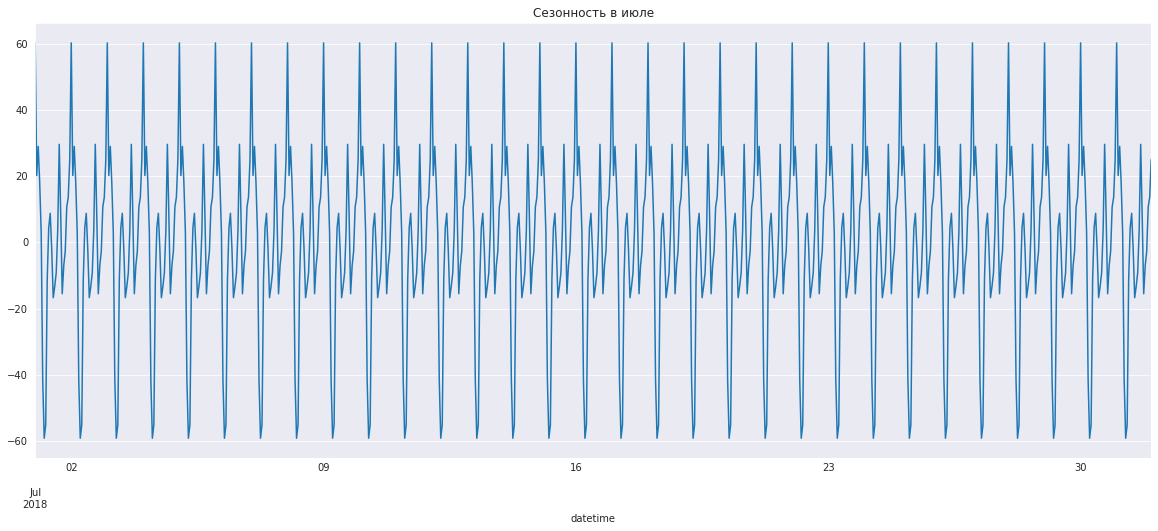

In [15]:
decomposed = seasonal_decompose(data['num_orders'])
decomposed.seasonal['2018-07-01':'2018-07-31'].plot(title='Сезонность в июле')
plt.show();

Линия на графике сезонности отображает станционарный стохастический процесс (переодичные колебания), распределение данных со временем не меняется, есть повторяющиеся закономерности.

Оценим сезонность на примере одного дня. Возьмем, например, середину июля.

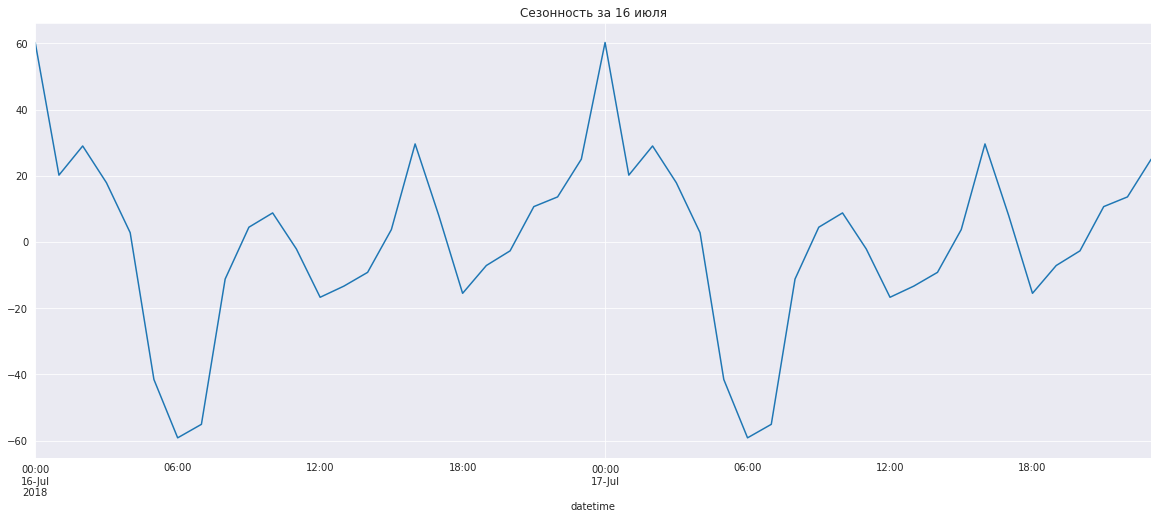

In [16]:
decomposed.seasonal['2018-07-16':'2018-07-17'].plot(ax=plt.gca(), title='Сезонность за 16 июля');

Для объективности построим аналогичный график для середины августа.

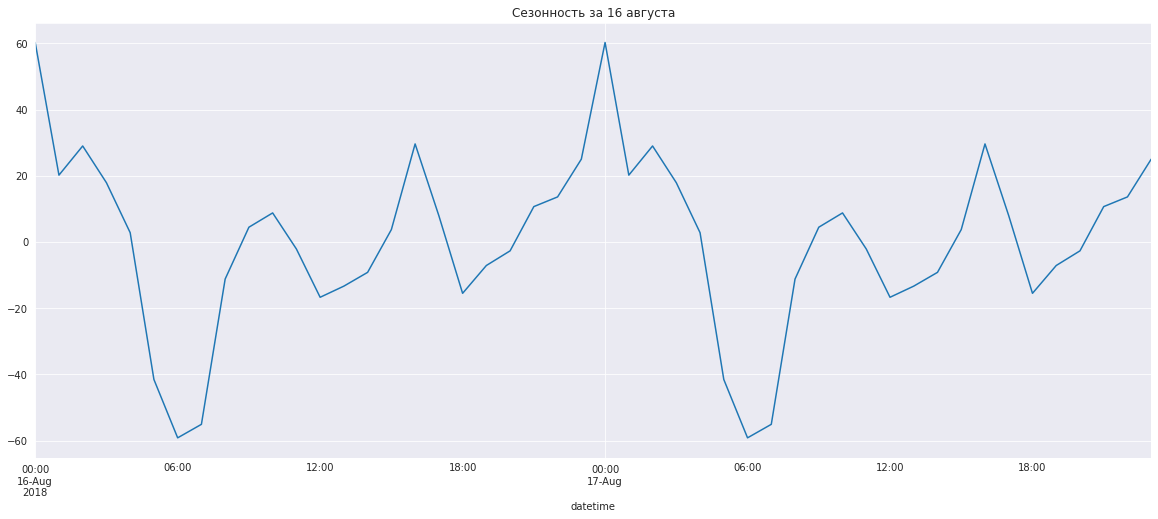

In [17]:
decomposed.seasonal['2018-08-16':'2018-08-17'].plot(ax=plt.gca(), title='Сезонность за 16 августа');

Графики очень похожи, отсюда делаем вывод, что в общем картина количества заказов такси ото дня ко дню схожа: количество заказов такси утром снижается, наименьшее количество наблюдаем в 6:00, а максимальное — около 12:00 ночи. Также имеются пики количества заказов в начале рабочего дня и к его концу.

**Вывод:**
    
Мы проанализировали временной ряд данных, представленных в датафрейме, сделали его стационарным для дальнейшей работы, добавили новые признаки для горизонта прогнозирования.

Также рассмотрели сезонность данных и треды, в результате получили следующую информацию.

* общее количество заказов такси растет из месяца в месяц, особенный рост наблюдается в июде—августе;
* в течение дня количество заказов снижается утром, наименьшее количество наблюдаем в 6:00, а максимальное — около 12:00 ночи.

## Обучение

Обучать будем две модели: `LinearRegression` и `LGBMRegressor`. Для подготовки признаков будем использовать функцию `make_features()`, написанную выше.

Данные будем разбивать на обучающую и тестовую выборки в соотношении 90% : 10%.

**LinearRegression**

In [19]:
rmse_ = 100

for lag in range(1, 50):
    for size in range(1, 50):
        df = make_features(data, lag, size)
        
        # разделение данных на обучающую, валидационную и тестовую выборки
        train, test = train_test_split(df, test_size=0.1, shuffle=False)
        train, validation = train_test_split(train, test_size=0.1, shuffle=False)

        train = train.dropna()

        features_train_lr = train.drop(['num_orders'], axis=1)
        target_train_lr = train['num_orders']
        
        features_validation_lr = validation.drop(['num_orders'], axis=1)
        target_validation_lr = validation['num_orders']
        
        features_test_lr = test.drop(['num_orders'], axis=1)
        target_test_lr = test['num_orders']
                
        lr = LinearRegression()
        lr.fit(features_train_lr, target_train_lr)
        
        predictions_validation_lr = lr.predict(features_validation_lr)
        rmse = mean_squared_error(target_validation_lr, predictions_validation_lr)**0.5

        if rmse < rmse_:
            rmse_ = rmse
            best_lag = lag
            best_rolling_size = size        

print('RMSE модели LinearRegression на валидационной выборке:', rmse_)
print('best_lag:', best_lag, 'best_rolling_size:', best_rolling_size)

RMSE модели LinearRegression на валидационной выборке: 31.64465175867965
best_lag: 49 best_rolling_size: 11


**LGBMRegressor**

In [21]:
rmse_ = 100

for lag in range(1, 50):
    for size in range(1, 50):
        df = make_features(data, lag, size)
        
        # разделение данных на обучающую, валидационную и тестовую выборки
        train, test = train_test_split(df, test_size=0.1, shuffle=False)
        train, validation = train_test_split(train, test_size=0.1, shuffle=False)

        train = train.dropna()

        features_train_lgbmr = train.drop(['num_orders'], axis=1)
        target_train_lgbmr = train['num_orders']
        
        features_validation_lgbmr = validation.drop(['num_orders'], axis=1)
        target_validation_lgbmr = validation['num_orders']
        
        features_test_lgbmr = test.drop(['num_orders'], axis=1)
        target_test_lgbmr = test['num_orders']
                
        lgbmr = LGBMRegressor()
        lgbmr.fit(features_train_lgbmr, target_train_lgbmr)
        
        predictions_validation_lgbmr = lgbmr.predict(features_validation_lgbmr)
        rmse = mean_squared_error(target_validation_lgbmr, predictions_validation_lgbmr)**0.5

        if rmse < rmse_:
            rmse_ = rmse
            best_lag = lag
            best_rolling_size = size        

print('RMSE модели LGBMRegressor на валидационной выборке:', rmse_)
print('best_lag:', best_lag, 'best_rolling_size:', best_rolling_size)

RMSE модели LGBMRegressor на валидационной выборке: 30.03853739133495
best_lag: 14 best_rolling_size: 24


**Вывод:**

Мы подготовиои признаки и обучили две модели: `LinearRegression` и `LGBMRegressor`. 

Лучшей в данном случае оказалась модель `LGBMRegressor` с *RMSE* — `30`, максимальным количеством отставаний — `14` и размером окна скользящего среднего — `24`. 

Модель `LinearRegression` имеет *RMSE* — `31.6`, при максимальном количестве отставаний — `49` и размером окна скользящего среднего — `11`.

## Тестирование

Проверим получившиеся модели на тестовой выборке.

**LinearRegression**

In [22]:
predictions_test_lr = lr.predict(features_test_lr)
print('RMSE модели LinearRegression на тестовой выборке:', mean_squared_error(target_test_lr, predictions_test_lr)**0.5)

RMSE модели LinearRegression на тестовой выборке: 42.0868004222847


**LGBMRegressor**

In [23]:
predictions_test_lgbmr = lgbmr.predict(features_test_lgbmr)
print('RMSE модели LightGBM на тестовой выборке:', mean_squared_error(target_test_lgbmr, predictions_test_lgbmr)**0.5)

RMSE модели LightGBM на тестовой выборке: 49.154333282921186


**Вывод:**

В соответствии с заданием значение метрики *RMSE* модели на тестовой выборке должно быть не больше `48`. Несмотря на то, что модель `LGBMRegressor` была определена как лучшая, значение *RMSE* на тестовой выборке равно `49`, что больше определенного заданием значения. А вот модель `LinearRegression` получает значение *RMSE*, равное `42`, что намного лучше и само по себе и удовлетворяет условию задачи. На валидационной выборке значения метрики *RMSE* обеих моделей ниже значения `48` и отличаются между собой незначительно.

Визуализируем результаты работы модели `LinearRegression`, сравним предсказанные ею значения и реальные тестовые значения.

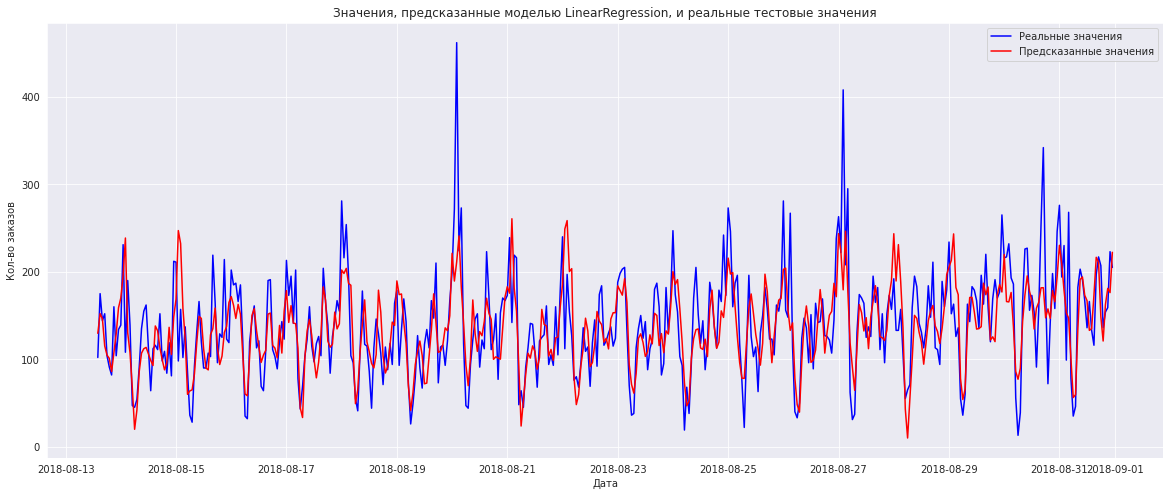

In [24]:
plt.plot(test.index, target_test_lr, color='b', label='Реальные значения')
plt.plot(test.index, predictions_test_lr, color='r', label='Предсказанные значения')

plt.xlabel('Дата')
plt.ylabel('Кол-во заказов')
plt.title('Значения, предсказанные моделью LinearRegression, и реальные тестовые значения')
plt.legend()
plt.grid(True)
plt.show();

Из графика видно, что модель в целом уловила изменение данных, но при этом пиковые значения привела ближе к средним, размах предсказанных значений не такой большой, как у реальных данных.

## Вывод

Для анализа был предоставлен временной ряд с данными о заказах такси в аэропортах. Для предсказания количества заказов такси на следующий час были обучены две модели (`LinearRegression` и `LGBMRegressor`) с подбором оптимальных параметров (максимального количества отставаний, размера окна скользящего среднего). 

На тестовой выборке лучший результат метрики *RMSE* продемонстрировала модель `LinearRegression`: `42`. Ее и рекомендуем использовать для предсказания количества заказов такси на следующий час.